# Deep Learning (RNN model)

## Imports

In [1]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf

2023-03-21 09:56:23.297320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 09:56:23.666014: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 09:56:23.688778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 09:56:23.688809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/home/galinasamotorova/code/GalinaSa/Final-Project'

## Import the data

In [3]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = 'data'
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [4]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

## Data cleaning

### Drop features with all NaN and >30% NaN values

In [6]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)
df.shape

(5813, 65)

### Drop features with std = 0

In [7]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

df.shape

(5813, 41)

### Drop corrected, 'choke' and correlated features, and from 'remove' dict

In [8]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

In [9]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

In [10]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P', 'Qliq MPFM', 'Qwat MPFM']
df.drop(columns=features_corr_drop, inplace = True)

In [11]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P", "Service Line P", "Manifold T", "Jumper T"}
df.drop(columns=remove, inplace=True)

In [12]:
df.shape

(5813, 14)

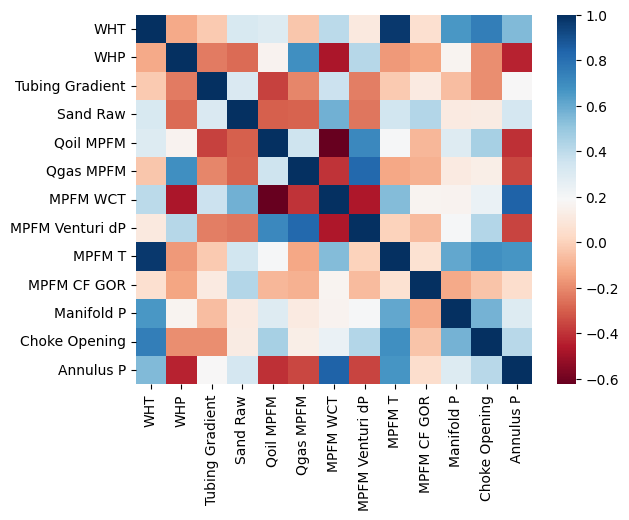

In [13]:
# Pairwise correlation
sns.heatmap(df.corr(), cmap='RdBu')
plt.show()

## Impute features

In [14]:
for feature in df.columns:
    df[feature].replace(np.nan, df[feature].median(), inplace=True)

In [15]:
df.isnull().sum()

Date               0
WHT                0
WHP                0
Tubing Gradient    0
Sand Raw           0
Qoil MPFM          0
Qgas MPFM          0
MPFM WCT           0
MPFM Venturi dP    0
MPFM T             0
MPFM CF GOR        0
Manifold P         0
Choke Opening      0
Annulus P          0
dtype: int64

In [16]:
df.head()

,Date,WHT,WHP,Tubing Gradient,Sand Raw,Qoil MPFM,Qgas MPFM,MPFM WCT,MPFM Venturi dP,MPFM T,MPFM CF GOR,Manifold P,Choke Opening,Annulus P
0,2007-02-01,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
1,2007-02-02,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
2,2007-02-03,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
3,2007-02-04,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353
4,2007-02-05,51.247467,78.146263,0.0,5084.182129,14065.431937,127.717811,0.0,1672.997986,52.371239,1.0,69.046879,76.917267,150.246353


## Feature selection

In [17]:
# starting the first model with 4 features only + our Target 'Qoil MPFM':

df_f = df[["Qoil MPFM","MPFM WCT", "Annulus P", "MPFM Venturi dP", "WHT", "WHP","Choke Opening"]].copy()

In [18]:
df_f.shape

(5813, 7)

In [324]:
df_f

,Qoil MPFM,MPFM WCT,Annulus P,MPFM Venturi dP,WHT,WHP,Choke Opening
0,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
1,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
2,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
3,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
4,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
...,...,...,...,...,...,...,...
5808,10925.670806,66.457010,147.032196,1687.935181,51.966740,65.511459,72.995338
5809,11142.564473,65.386773,147.082047,1719.284912,51.968021,65.433243,72.484528
5810,11140.120568,65.647569,147.067032,1742.380127,51.972717,65.115013,73.002724
5811,11400.139595,64.967486,147.128189,1729.632324,51.982071,64.796227,72.730721


In [19]:
df_f.describe()

,Qoil MPFM,MPFM WCT,Annulus P,MPFM Venturi dP,WHT,WHP,Choke Opening
count,5813.000000,5813.000000,5813.000000,5813.000000,5813.000000,5813.000000,5813.000000
mean,15655.948879,38.143842,139.765149,2314.415108,48.902811,82.228238,76.908024
std,8820.271696,24.478523,24.254480,1608.667626,8.115710,18.409271,19.746536
min,0.000000,-0.605886,18.328125,-17.657236,2.044475,1.013250,-0.251513
25%,9795.177134,12.084156,114.992844,1045.770996,49.808365,73.542336,71.080894
50%,14065.431937,49.305413,150.246353,1672.997986,51.247467,78.146263,76.917267
75%,18393.306228,59.913923,157.666885,3816.651123,51.697182,82.110954,89.220985
max,49223.595339,91.660984,168.035065,6859.150391,52.393002,216.446396,101.011047


## Visualizing Time Series

In [20]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = df_f.shape[1] - 1

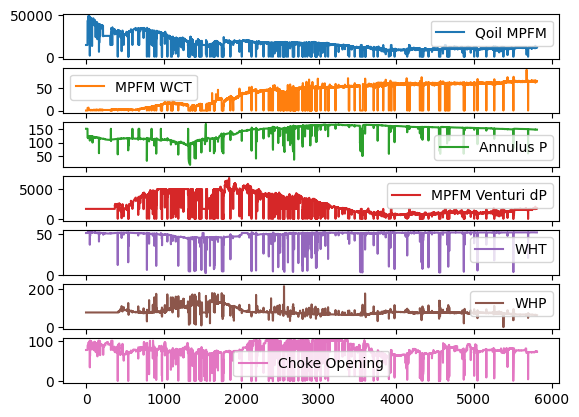

In [21]:
plot_cols = [TARGET, "MPFM WCT", "Annulus P", "MPFM Venturi dP", "WHT", "WHP","Choke Opening"]
plot_features = df_f[plot_cols]
plot_features.index = df_f.index
plot_features.plot(subplots = True);

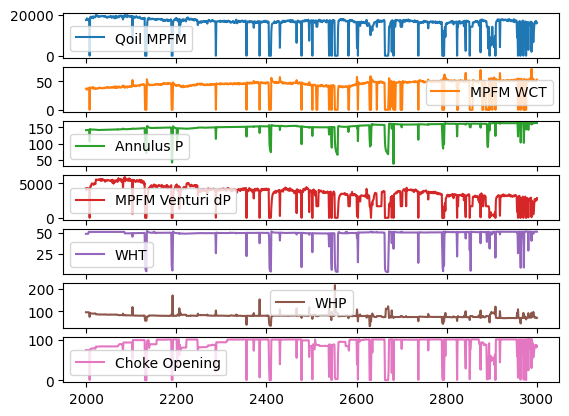

In [22]:
zoomed_slice = slice(2000,3000)

plot_features = df_f.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## Preparing the dataset

In [152]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 365 * 9 # nine years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 91 # 3 months

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [153]:
def get_folds(
    df_f: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    fold_list = []
    
    
    for i in range(0, len(df_f), fold_stride):
        if i + fold_length >= len(df_f):
            break
        fold_list.append(df_f[i:fold_length])
    
    return fold_list

In [154]:
folds = get_folds(df_f, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 28 folds.
Each fold has a shape equal to (3285, 7).


### Temporal Train/Test split

Let's focus on one fold

In [155]:
fold = folds[0]
fold

,Qoil MPFM,MPFM WCT,Annulus P,MPFM Venturi dP,WHT,WHP,Choke Opening
0,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
1,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
2,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
3,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
4,14065.431937,0.000000,150.246353,1672.997986,51.247467,78.146263,76.917267
...,...,...,...,...,...,...,...
3280,13847.190782,53.188693,164.850006,1765.942017,51.658119,65.955971,100.092194
3281,13805.912747,53.813445,164.846222,1798.200317,51.588806,66.075676,100.254662
3282,14022.647480,52.981063,164.897873,1781.037720,51.621613,66.310822,100.330078
3283,13517.461733,54.374691,164.915909,1801.078979,51.593250,66.022469,100.383385


☝️ We want to split this fold chronologically into:

- train dataframe
- test dataframe

that will contain all the data we need to be able to sample many (X_i, y_i) pairs in each dataframe in a next step!

The INPUT_LENGTH of each X_i is going to be equal to 2 weeks (*but we can change it*)

In [188]:
INPUT_LENGTH = 14 # two weeks

In [189]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [190]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [191]:
print(f'Each fold has a shape equal to {fold.shape}.')
print(f'Each fold_train has a shape equal to {fold_train.shape}.')
print(f'Each fold_test has a shape equal to {fold_test.shape}.')

Each fold has a shape equal to (3285, 7).
Each fold_train has a shape equal to (2168, 7).
Each fold_test has a shape equal to (1131, 7).


### Create (X, y) sequences

Now that we have splitted our fold into a train set and a test set, it is time to:

- sample lots of sequences (Xi,yi) on which the model will be trained
- sample lots of sequences (Xi,yi)on which the model will be evaluated

Our goal is to create 3D-arrays (X_train, y_train) and (X_test, y_test) containing all the SEQUENCES we need from this fold:

- X_train.shape = (n_samples_train, input_length, n_features)
- y_train.shape = (n_samples_train, output_length, n_targets)

In [192]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 6
INPUT_LENGTH = 14 days = 2 weeks


X is the input of our model.

- It contains 7 features: the past values of the target + 6 past-covariates
- Each sequence has a length equal to 2 weeks

In [193]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


y is the target that we want to predict

- It is the value at the single next timestep (= next day)
 - We could also predict OUTPUT_LENGTH > 1, i.e several values in the future (2, 3 days later,...) but let's keep it simple here and just try to predict the next point (next day)

### Creating the (X,y) sequences by random sampling in each fold

Generating one random sequence

In [194]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [195]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [196]:
X_train_i.shape

(14, 7)

In [197]:
# Advanced check 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

Generating multiple random sequence

In [198]:
SEQUENCE_STRIDE = 1 #temporal stride of 1 day

In [199]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [200]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 3285 days
= 469 weeks


In [201]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(2153, 14, 7)
(2153, 1, 1)


## DL Modeling

### Baseline Model : predict the "last seen value" to compare with our LSTM

In [202]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import models
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization

def init_baseline():

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [203]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {baseline_score[1]} barrels")

35/35 [==============================] - 0s 4ms/step - loss: 240270608.0000 - mae: 14995.3125
- The Baseline MAE on the test set is equal to 14995.3125 barrels


### RNN : the LSTM

In [204]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [279]:
def init_model(X_train, y_train):
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(256, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [280]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_23 (Normaliza  (None, None, 7)          15        
 tion)                                                           
                                                                 
 lstm_23 (LSTM)              (None, 256)               270336    
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 270,608
Trainable params: 270,593
Non-trainable params: 15
_________________________________________________________________


In [282]:
from tensorflow.keras.callbacks import EarlyStopping
from typing import Dict, List, Tuple, Sequence

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 120,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [283]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_24 (Normaliza  (None, None, 7)          15        
 tion)                                                           
                                                                 
 lstm_24 (LSTM)              (None, 256)               270336    
                                                                 
 dense_24 (Dense)            (None, 1)                 257       
                                                                 
Total params: 270,608
Trainable params: 270,593
Non-trainable params: 15
_________________________________________________________________
Epoch 1/120
95/95 [==============================] - 7s 40ms/step - loss: 775989632.0000 - mae: 26167.0312 - val_loss: 269479136.0000 - val_mae: 15765.0264
Epoch 2/120
95/95 [==============================] - 3s 37ms/step - loss: 760773312.0000

Epoch 48/120
95/95 [==============================] - 3s 35ms/step - loss: 268771776.0000 - mae: 14506.4062 - val_loss: 31062324.0000 - val_mae: 4987.3843
Epoch 49/120
95/95 [==============================] - 3s 35ms/step - loss: 261834736.0000 - mae: 14272.5742 - val_loss: 28405320.0000 - val_mae: 4731.7827
Epoch 50/120
95/95 [==============================] - 3s 35ms/step - loss: 256353008.0000 - mae: 14088.2393 - val_loss: 26991404.0000 - val_mae: 4501.7524
Epoch 51/120
95/95 [==============================] - 3s 34ms/step - loss: 249454608.0000 - mae: 13856.5127 - val_loss: 26449644.0000 - val_mae: 4390.7671
Epoch 52/120
95/95 [==============================] - 3s 34ms/step - loss: 241679456.0000 - mae: 13593.6191 - val_loss: 27935006.0000 - val_mae: 4478.0439
Epoch 53/120
95/95 [==============================] - 3s 32ms/step - loss: 234944928.0000 - mae: 13397.6562 - val_loss: 32403478.0000 - val_mae: 4522.0571
Epoch 54/120
95/95 [==============================] - 2s 24ms/step - l

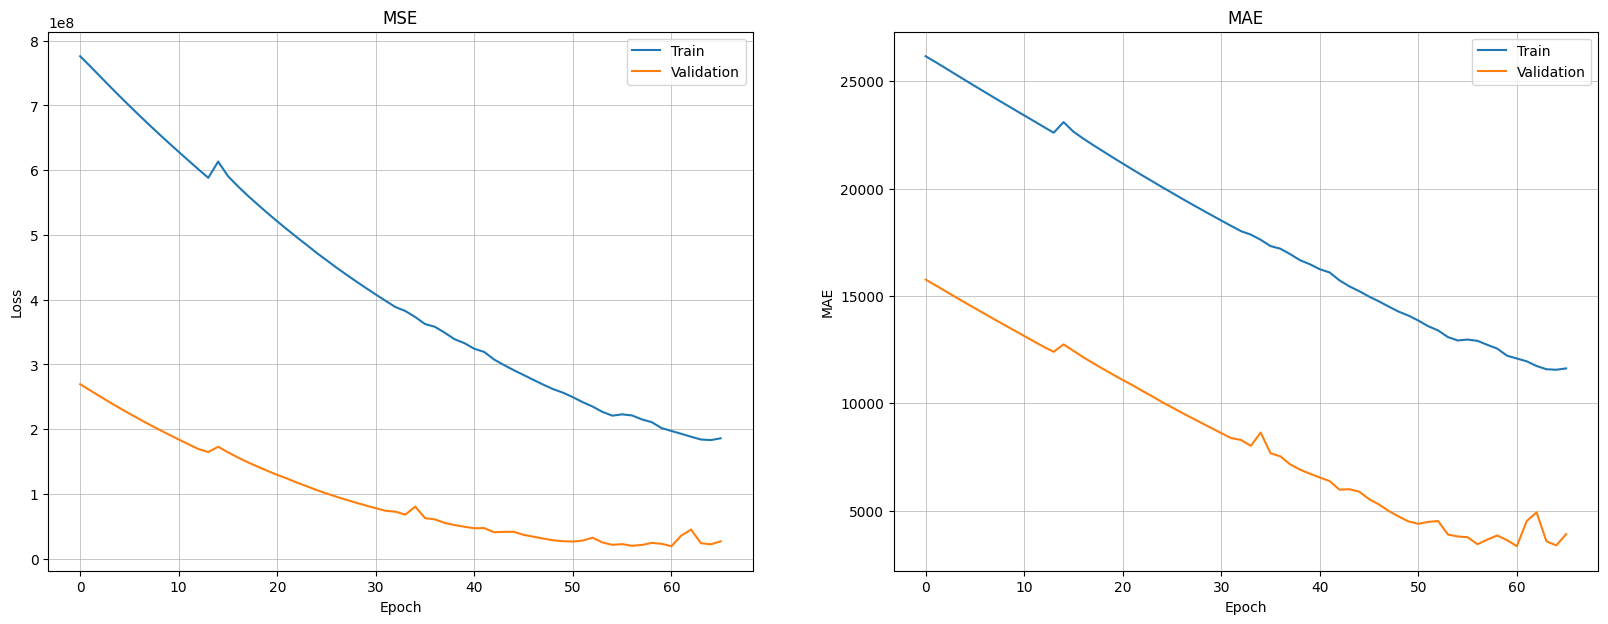

In [284]:
plot_history(history);

In [285]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {res[1]} barrels")

35/35 [==============================] - 1s 14ms/step - loss: 15525725.0000 - mae: 2014.7836
The LSTM MAE on the test set is equal to 2014.7835693359375 barrels


In [286]:
print(f"- The LSTM MAE on the test set is equal to {res[1]} barrels")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} % 🔥")

- The LSTM MAE on the test set is equal to 2014.7835693359375 barrels
🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : 86.56 % 🔥


### Cross-Validation

In [287]:
# Reminders of the global variables in this notebook

print(f'N_FEATURES = {N_FEATURES}') 
print(f'N_TARGETS = {N_TARGETS}') 
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')

print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_FEATURES = 6
N_TARGETS = 1

FOLD_LENGTH = 3285
FOLD_STRIDE = 91
TRAIN_TEST_RATIO = 0.66

INPUT_LENGTH = 14
OUTPUT_LENGTH = 1


In [288]:
#  how many folds we have 
folds = get_folds(df_f, FOLD_LENGTH, FOLD_STRIDE)

print(f" we have {len(folds)} FOLDS")

 we have 28 FOLDS


In [289]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(df_f, FOLD_LENGTH, FOLD_STRIDE)
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)                   

        X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 5, 
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 16,
                            epochs = 100,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [290]:
%%time
# WARNING : it takes 60 minutes to run this cell 
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

--------------------------------------------------
MAE baseline fold n°0 = 14995.31
MAE LSTM fold n°0 = 7557.64
🏋🏽‍♂️ improvement over baseline: 49.6 % 

--------------------------------------------------
MAE baseline fold n°1 = 14980.55
MAE LSTM fold n°1 = 3274.64
🏋🏽‍♂️ improvement over baseline: 78.14 % 

--------------------------------------------------
MAE baseline fold n°2 = 14918.11
MAE LSTM fold n°2 = 13958.72
🏋🏽‍♂️ improvement over baseline: 6.43 % 

--------------------------------------------------
MAE baseline fold n°3 = 14855.89
MAE LSTM fold n°3 = 2791.66
🏋🏽‍♂️ improvement over baseline: 81.21 % 

--------------------------------------------------
MAE baseline fold n°4 = 14814.62
MAE LSTM fold n°4 = 1938.88
🏋🏽‍♂️ improvement over baseline: 86.91 % 

--------------------------------------------------
MAE baseline fold n°5 = 14756.38
MAE LSTM fold n°5 = 2648.4
🏋🏽‍♂️ improvement over baseline: 82.05 % 

--------------------------------------------------
MAE baseline fold n°6

In [291]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = 65.0%


In [322]:
X_test.shape, y_test.shape

((1116, 14, 7), (1116, 1, 1))

In [338]:
features = pd.DataFrame(X_test[:,0],
                 columns=["Qoil MPFM Real","MPFM WCT", "Annulus P", "MPFM Venturi dP", "WHT", "WHP","Choke Opening"])
features

,Qoil MPFM Real,MPFM WCT,Annulus P,MPFM Venturi dP,WHT,WHP,Choke Opening
0,17314.554926,44.993297,148.336685,4600.971191,49.920815,80.451302,88.408333
1,17670.793776,44.491959,148.471054,4698.059082,49.928555,80.789749,88.678017
2,17453.841372,44.681557,148.501297,4479.698242,49.951077,79.934982,88.353958
3,17556.162896,45.533877,149.328171,4418.763672,50.314072,80.147614,99.758553
4,17498.254331,44.968968,148.816071,4383.696777,50.182426,79.850708,99.712387
...,...,...,...,...,...,...,...
1111,14368.789387,51.954152,165.297897,1829.494751,51.586681,66.296234,100.408653
1112,13973.439999,53.228272,165.299210,1828.518921,51.590042,66.345024,100.386848
1113,13826.439474,53.326576,165.268906,1738.906250,51.630058,66.528564,100.289116
1114,13874.553993,53.525749,165.220566,1783.643555,51.616470,66.313080,100.693344


In [370]:
oil_r = features[["Qoil MPFM Real"]].copy()
oil_r

,Qoil MPFM Real
0,17314.554926
1,17670.793776
2,17453.841372
3,17556.162896
4,17498.254331
...,...
1111,14368.789387
1112,13973.439999
1113,13826.439474
1114,13874.553993


In [337]:
# 4 - Prediction
# ====================================
y_pred = model.predict(X_test)
y_pred.shape

35/35 [==============================] - 0s 10ms/step


(1116, 1)

In [341]:
prediction = pd.DataFrame(y_pred, columns =['Qoil Predicted'])
prediction

,Qoil Predicted
0,15556.198242
1,15592.027344
2,15633.672852
3,15717.927734
4,15710.238281
...,...
1111,15670.869141
1112,15671.826172
1113,15668.145508
1114,15671.620117


<AxesSubplot:>

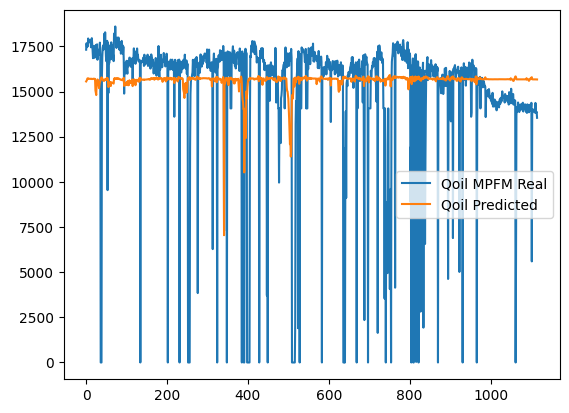

In [373]:
results=pd.concat([oil_r,prediction],axis=1)
results.plot()

## Exporting model

In [320]:
from tensorflow.keras import models

# Saving the model:
models.save_model(model, 'my_RNN_model')

# Loading the model:
#loaded_model = models.load_model('my_model')


INFO:tensorflow:Assets written to: my_RNN_model/assets


INFO:tensorflow:Assets written to: my_RNN_model/assets


In [321]:
!ls

 basic_mvp.ipynb
 data
'galina - deep_learning.ipynb'
 MLops
 my_model
 my_RNN_model
'Oil-production - data-cleaning_In-Progress.ipynb'
 working_GS_old
